In [1]:
import tskit
import msprime
import subprocess

In [2]:
sample_size = 10
seq_length = 1e4
rec_rate = 1e-9
rho = 2 * rec_rate * seq_length
replicates = 2

# Simulate a simple coalescent tree sequence
ts_msprime = msprime.sim_ancestry(
    samples=sample_size,
    sequence_length=seq_length,
    recombination_rate=rec_rate,
    population_size=0.25,
    ploidy=1,
    random_seed=42,
    num_replicates=replicates,
)

subprocess.run(["../discoal", f"{sample_size}", f"{replicates}", f"{seq_length}", "-r", "100", "-ts", "foo.ts"])



../discoal 10 2 10000.0 -r 100 -ts foo.ts 
1956873445 384570567


CompletedProcess(args=['../discoal', '10', '2', '10000.0', '-r', '100', '-ts', 'foo.ts'], returncode=0)

In [7]:
ts_discoal = tskit.load("foo.ts")
ts_discoal

In [11]:
import numpy as np
import pandas as pd

# Comprehensive function to analyze tree sequences from multiple replicates
def analyze_tree_sequences(output_prefix, reps, source="discoal"):
    """
    Analyze multiple replicate tree sequences and compute summary statistics.
    
    Parameters:
    - output_prefix: Base name for output files (e.g., "discoal_output" or "msprime_output")
    - reps: Number of replicates to analyze
    - source: Either "discoal" or "msprime" to handle file naming conventions
    """
    
    all_stats = []
    
    for i in range(1, reps + 1):
        # Load tree sequence
        if source == "discoal":
            tree_file_path = f"{output_prefix}_rep{i}.ts"
        else:  # msprime
            tree_file_path = f"{output_prefix}_rep{i}.ts"
        
        try:
            ts = tskit.load(tree_file_path)
        except FileNotFoundError:
            print(f"Warning: Could not find {tree_file_path}, skipping...")
            continue
        
        # Calculate tree heights
        tree_heights = []
        tree_spans = []
        num_roots_per_tree = []
        
        for tree in ts.trees():
            # Get all roots (there may be multiple in case of non-coalescence)
            roots = tree.roots
            num_roots_per_tree.append(len(roots))
            
            # For each root, calculate the tree height
            if len(roots) > 0:
                max_height = max(tree.time(root) for root in roots)
                tree_heights.append(max_height)
                tree_spans.append(tree.span)
        
        # Calculate diversity metrics
        diversity = ts.diversity(mode="branch") if ts.num_samples > 1 else 0
        
        # Calculate segregating sites
        segregating_sites = ts.segregating_sites(mode="branch")
        
        # Store statistics for this replicate
        stats = {
            "replicate": i,
            "num_samples": ts.num_samples,
            "num_trees": ts.num_trees,
            "num_sites": ts.num_sites,
            "num_mutations": ts.num_mutations,
            "num_nodes": ts.num_nodes,
            "num_edges": ts.num_edges,
            "sequence_length": ts.sequence_length,
            "mean_tree_height": np.average(tree_heights, weights=tree_spans) if tree_heights else 0,
            "max_tree_height": max(tree_heights) if tree_heights else 0,
            "min_tree_height": min(tree_heights) if tree_heights else 0,
            "diversity": diversity,
            "segregating_sites": segregating_sites,
            "mean_roots_per_tree": np.mean(num_roots_per_tree),
            "max_roots_per_tree": max(num_roots_per_tree) if num_roots_per_tree else 0,
            "fully_coalesced": all(n == 1 for n in num_roots_per_tree)
        }
        
        all_stats.append(stats)
    
    # Convert to DataFrame for easy analysis
    df = pd.DataFrame(all_stats)
    print(df.head())  # Print first few rows for verification
    # Print summary across all replicates
    print(f"\n{'='*60}")
    print(f"Summary statistics for {source} ({len(df)} replicates analyzed)")
    print(f"{'='*60}\n")
    
    # Basic counts
    print("Basic metrics (mean ± std):")
    print(f"  Samples: {df['num_samples'].iloc[0] if len(df) > 0 else 'N/A'}")  # Should be constant
    print(f"  Trees: {df['num_trees'].mean():.1f} ± {df['num_trees'].std():.1f}")
    print(f"  Sites: {df['num_sites'].mean():.1f} ± {df['num_sites'].std():.1f}")
    print(f"  Mutations: {df['num_mutations'].mean():.1f} ± {df['num_mutations'].std():.1f}")
    print(f"  Nodes: {df['num_nodes'].mean():.1f} ± {df['num_nodes'].std():.1f}")
    print(f"  Edges: {df['num_edges'].mean():.1f} ± {df['num_edges'].std():.1f}")
    
    # Tree structure
    print("\nTree structure:")
    print(f"  Mean tree height: {df['mean_tree_height'].mean():.4f} ± {df['mean_tree_height'].std():.4f}")
    print(f"  Max tree height: {df['max_tree_height'].mean():.4f} ± {df['max_tree_height'].std():.4f}")
    print(f"  Mean roots per tree: {df['mean_roots_per_tree'].mean():.3f} ± {df['mean_roots_per_tree'].std():.3f}")
    print(f"  Fully coalesced replicates: {df['fully_coalesced'].sum()}/{len(df)} ({100*df['fully_coalesced'].mean():.1f}%)")
    
    # Genetic diversity
    print("\nGenetic diversity:")
    print(f"  Pairwise diversity (π): {df['diversity'].mean():.6f} ± {df['diversity'].std():.6f}")
    print(f"  Segregating sites (S): {df['segregating_sites'].mean():.6f} ± {df['segregating_sites'].std():.6f}")
    
    return df

# Function to compare statistics between simulators
def compare_simulators(df_msprime, df_discoal):
    """Compare summary statistics between msprime and discoal outputs."""
    
    print(f"\n{'='*60}")
    print("Comparison between msprime and discoal")
    print(f"{'='*60}\n")
    
    # Metrics to compare
    metrics = [
        ("num_trees", "Number of trees"),
        ("num_sites", "Number of sites"), 
        ("num_mutations", "Number of mutations"),
        ("mean_tree_height", "Mean tree height"),
        ("diversity", "Pairwise diversity"),
        ("segregating_sites", "Segregating sites"),
        ("mean_roots_per_tree", "Mean roots per tree")
    ]
    
    for metric, label in metrics:
        msp_mean = df_msprime[metric].mean()
        dis_mean = df_discoal[metric].mean()
        
        # Perform t-test
        from scipy import stats
        t_stat, p_value = stats.ttest_ind(df_msprime[metric], df_discoal[metric])
        
        print(f"{label}:")
        print(f"  msprime: {msp_mean:.6f}")
        print(f"  discoal: {dis_mean:.6f}")
        print(f"  Difference: {abs(msp_mean - dis_mean):.6f} ({100*abs(msp_mean - dis_mean)/msp_mean:.1f}%)")
        print(f"  t-test p-value: {p_value:.4f} {'*' if p_value < 0.05 else ''}")
        print()

# Simple function to summarize a single tree sequence
def summarize_single_ts(ts, label):
    """Summarize a single tree sequence."""
    print(f"\nSummary statistics for {label}:")
    print(f"  Number of samples: {ts.num_samples}")
    print(f"  Number of trees: {ts.num_trees}")
    print(f"  Number of sites: {ts.num_sites}")
    print(f"  Number of mutations: {ts.num_mutations}")
    print(f"  Number of nodes: {ts.num_nodes}")
    print(f"  Number of edges: {ts.num_edges}")
    print(f"  Sequence length: {ts.sequence_length}")
    
    # Calculate tree heights
    tree_heights = []
    tree_spans = []
    for tree in ts.trees():
        if tree.num_roots == 1:
            tree_heights.append(tree.time(tree.root))
            tree_spans.append(tree.span)
    
    if tree_heights:
        mean_height = np.average(tree_heights, weights=tree_spans)
        print(f"  Mean tree height: {mean_height:.4f}")
    
    # Diversity
    if ts.num_samples > 1:
        print(f"  Mean pairwise diversity (π): {ts.diversity(mode='branch'):.6f}")
        print(f"  Segregating sites (S): {ts.segregating_sites(mode='branch'):.6f}")

# Example usage with the loaded tree sequences
#summarize_single_ts(ts_msprime, "msprime (single replicate)")
#summarize_single_ts(ts_discoal, "discoal (single replicate)")

In [27]:
# Example: Generate multiple replicates and analyze them
# This shows how to use the analysis functions with multiple simulations

# First, let's generate some example data
import os

# Parameters for simulation
n_reps = 100
sample_size = 20
seq_length = 1e5
theta = 10  # 4*Ne*mu*L
rho = 100    # 4*Ne*r*L

print("Generating test data...")

# Generate msprime replicates
msprime_files = []
for i in range(1, n_reps + 1):
    ts = msprime.sim_ancestry(
        samples=sample_size,
        sequence_length=seq_length,
        recombination_rate=rho / seq_length / 2,  # Convert to per-bp rate
        population_size=1,  # Ne=0.5 for diploid samples
        ploidy=1,
        random_seed=42 + i
    )
    # Add mutations
    ts = msprime.sim_mutations(
        ts,
        rate=theta / seq_length / 2,  # Convert to per-bp rate
        random_seed=142 + i
    )
    filename = f"msprime_test_rep{i}.ts"
    ts.dump(filename)
    msprime_files.append(filename)

# Generate discoal replicates
print("\nRunning discoal simulations...")

cmd = [
    "../discoal",
    str(sample_size),
    str(n_reps),
    str(int(seq_length)),
    "-t", str(theta),
    "-r", str(rho),
    "-d", str(100 + i), str(100 + i),
    "-ts","discoal_test.ts",
    "-F",
]
result = subprocess.run(cmd, capture_output=True, text=True)
if result.returncode != 0:
    print(f"Error in replicate {i}: {result.stderr}")

print("\nAnalyzing tree sequences...")

# Analyze both sets of replicates
df_msprime = analyze_tree_sequences("msprime_test", n_reps, source="msprime")
df_discoal = analyze_tree_sequences("discoal_test", n_reps, source="discoal")

# Compare the two simulators
if len(df_msprime) > 0 and len(df_discoal) > 0:
    compare_simulators(df_msprime, df_discoal)

# Clean up test files
print("\nCleaning up test files...")
for i in range(1, n_reps + 1):
    try:
        os.remove(f"msprime_test_rep{i}.ts")
        os.remove(f"discoal_test_rep{i}.trees")
    except:
        pass

Generating test data...

Running discoal simulations...

Analyzing tree sequences...
   replicate  num_samples  num_trees  num_sites  num_mutations  num_nodes  \
0          1           20        263         40             40        219   
1          2           20        269         30             30        248   
2          3           20        241         22             22        215   
3          4           20        226         30             30        202   
4          5           20        291         36             36        254   

   num_edges  sequence_length  mean_tree_height  max_tree_height  \
0        866         100000.0          2.052374         7.919236   
1        854         100000.0          1.964980         7.006147   
2        808         100000.0          1.618304         4.127522   
3        802         100000.0          1.403398         6.357085   
4        993         100000.0          2.096999         5.449543   

   min_tree_height  diversity  segregating_

/home/adkern/miniforge3/envs/discoal_dev/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [28]:
# Visualization function for comparing tree sequences
import matplotlib.pyplot as plt

def plot_tree_sequence_comparison(df_msprime, df_discoal):
    """Create visualizations comparing msprime and discoal tree sequences."""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Comparison of Tree Sequence Statistics: msprime vs discoal', fontsize=16)
    
    # Metrics to plot
    metrics = [
        ('num_trees', 'Number of Trees'),
        ('mean_tree_height', 'Mean Tree Height'),
        ('diversity', 'Pairwise Diversity (π)'),
        ('num_sites', 'Number of Sites'),
        ('num_mutations', 'Number of Mutations'),
        ('segregating_sites', 'Segregating Sites')
    ]
    
    for idx, (metric, title) in enumerate(metrics):
        ax = axes[idx // 3, idx % 3]
        
        # Create box plots
        data = [df_msprime[metric], df_discoal[metric]]
        bp = ax.boxplot(data, labels=['msprime', 'discoal'], patch_artist=True)
        
        # Color the boxes
        colors = ['lightblue', 'lightgreen']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        # Add title and labels
        ax.set_title(title)
        ax.set_ylabel('Value')
        
        # Add mean values as text
        for i, (df, label) in enumerate([(df_msprime, 'msprime'), (df_discoal, 'discoal')]):
            mean_val = df[metric].mean()
            ax.text(i+1, ax.get_ylim()[1]*0.95, f'μ={mean_val:.3f}', 
                   ha='center', va='top', fontsize=10)
    
    plt.tight_layout()
    return fig

# Function to create a detailed tree height distribution plot
def plot_tree_height_distribution(output_prefix, n_reps=10, source="discoal"):
    """Plot the distribution of tree heights across the sequence."""
    
    all_heights = []
    all_positions = []
    
    for i in range(1, n_reps + 1):
        if source == "discoal":
            tree_file = f"{output_prefix}_rep{i}.trees"
        else:
            tree_file = f"{output_prefix}_rep{i}.ts"
            
        try:
            ts = tskit.load(tree_file)
            
            for tree in ts.trees():
                if tree.num_roots == 1:
                    height = tree.time(tree.root)
                    # Record height at the midpoint of the tree's interval
                    midpoint = (tree.interval[0] + tree.interval[1]) / 2
                    all_heights.append(height)
                    all_positions.append(midpoint)
        except:
            continue
    
    if all_heights:
        plt.figure(figsize=(12, 6))
        
        # Subplot 1: Heights along sequence
        plt.subplot(1, 2, 1)
        plt.scatter(all_positions, all_heights, alpha=0.5, s=1)
        plt.xlabel('Position along sequence')
        plt.ylabel('Tree height')
        plt.title(f'Tree Heights Along Sequence ({source})')
        
        # Subplot 2: Height distribution
        plt.subplot(1, 2, 2)
        plt.hist(all_heights, bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Tree height')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Tree Heights ({source})')
        plt.axvline(np.mean(all_heights), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(all_heights):.3f}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Example usage (uncomment to use with your data):
# plot_tree_height_distribution("discoal_test", n_reps=10, source="discoal")
# plot_tree_height_distribution("msprime_test", n_reps=10, source="msprime")

# If you have the dataframes from the analysis:
# fig = plot_tree_sequence_comparison(df_msprime, df_discoal)
# plt.show()

/tmp/ipykernel_286341/2157007032.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=['msprime', 'discoal'], patch_artist=True)
/tmp/ipykernel_286341/2157007032.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=['msprime', 'discoal'], patch_artist=True)
/tmp/ipykernel_286341/2157007032.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=['msprime', 'discoal'], patch_artist=True)
/tmp/ipykernel_286341/2157007032.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotl

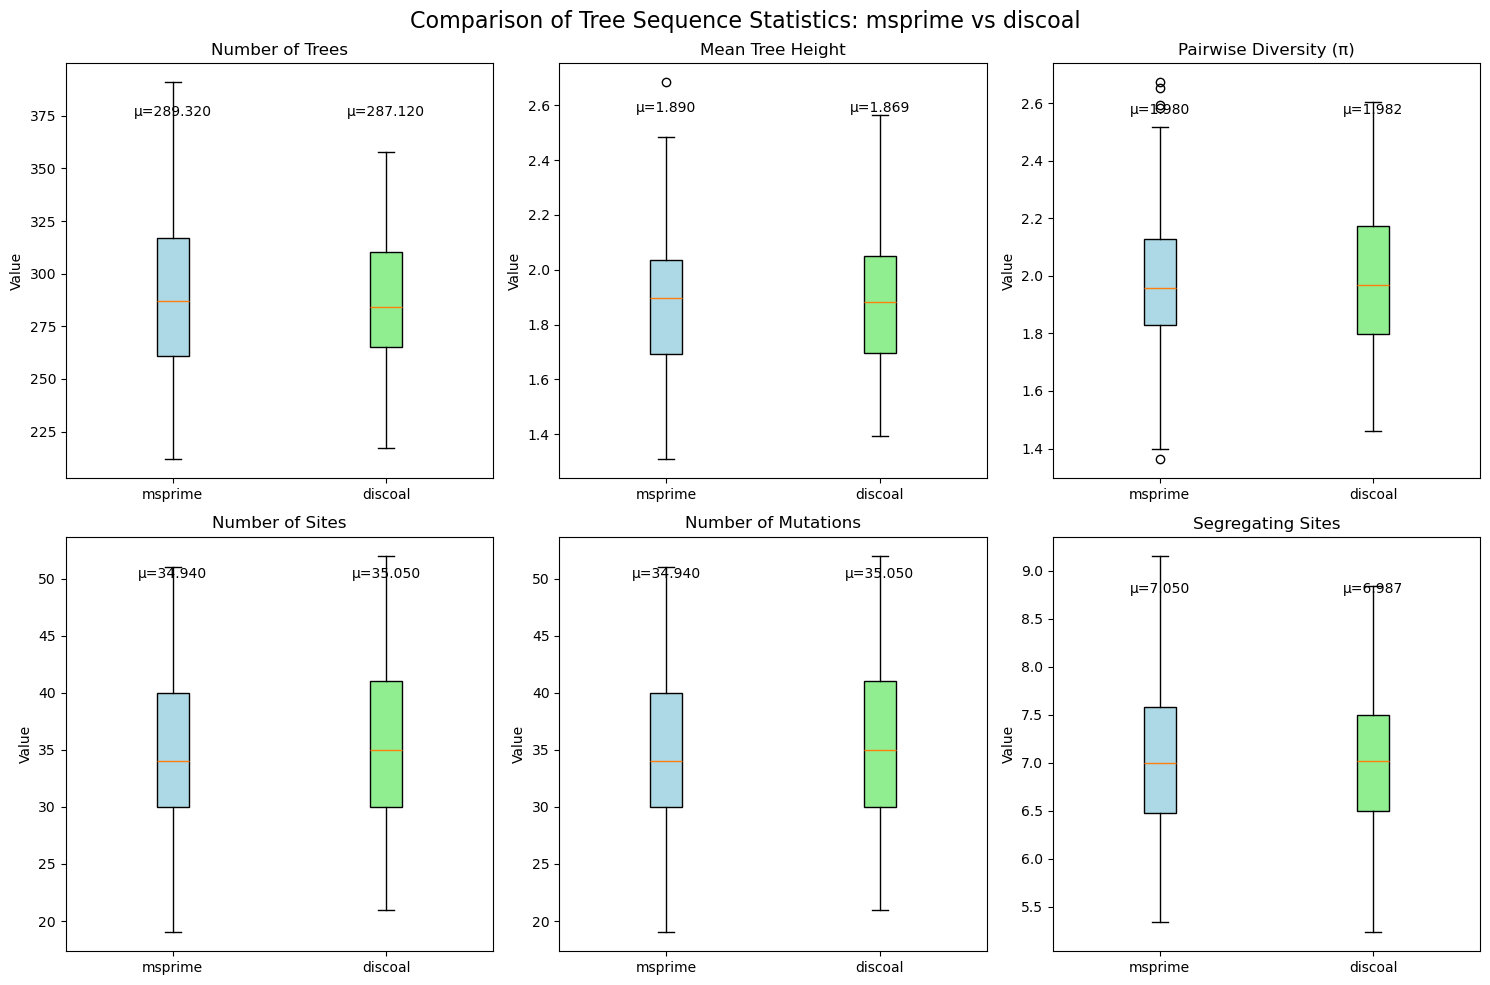

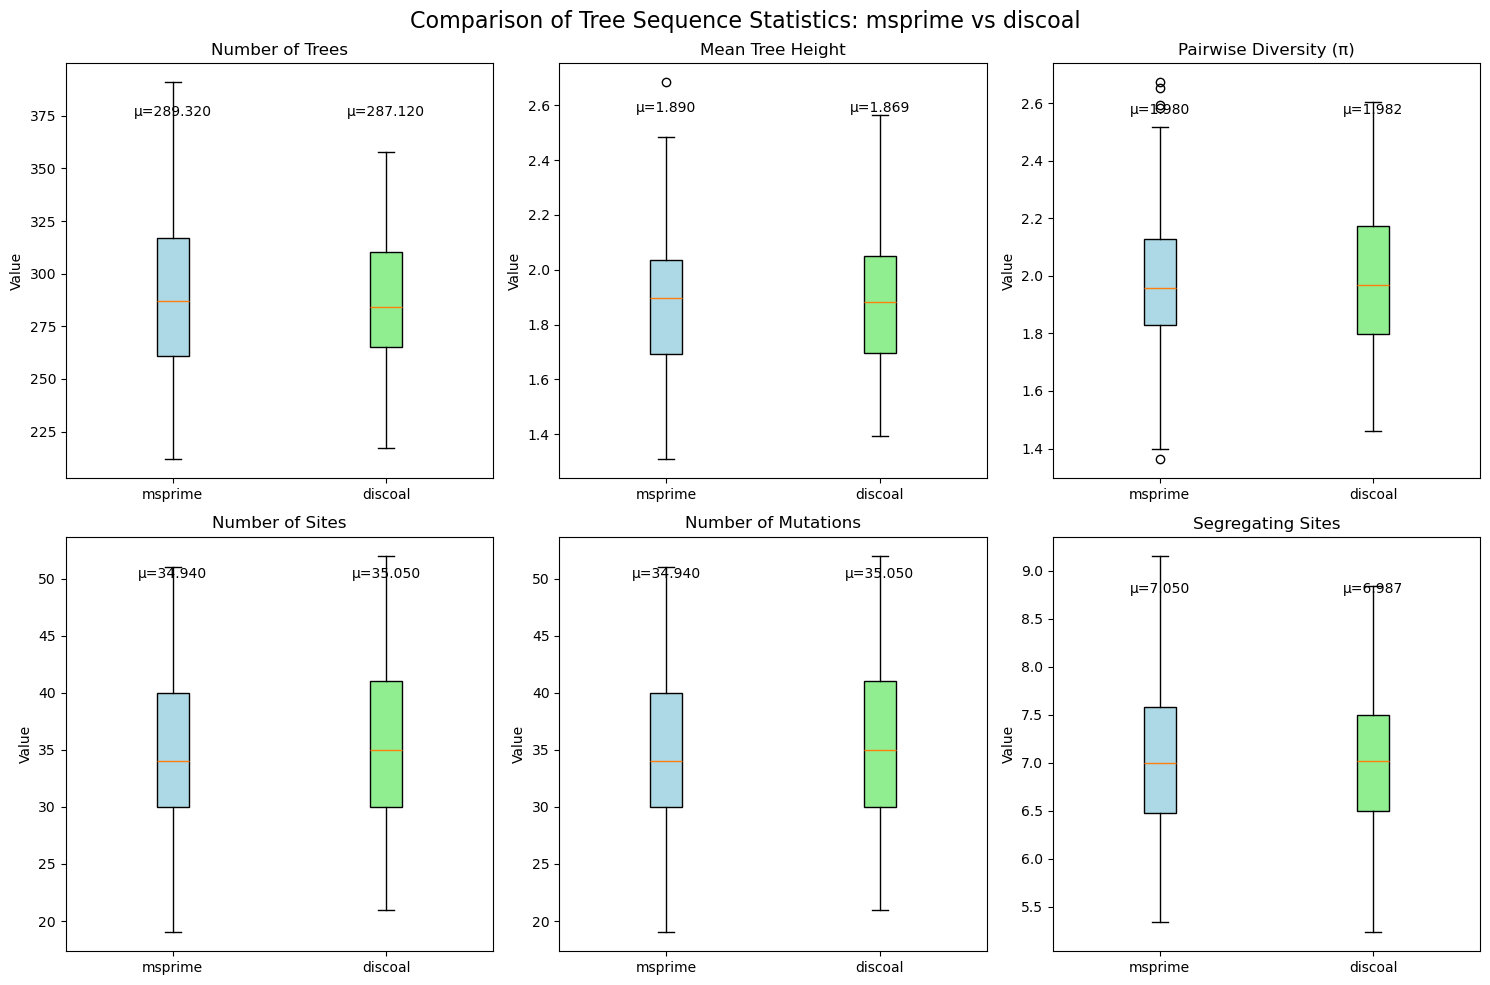

In [26]:
plot_tree_sequence_comparison(df_discoal, df_msprime)